Passos -> \
- Objetivo: prever Beats Per Minute
- Métrica de Avaliação: RMSE
- Tipo de Modelo: Regrssão
- EDA
    - Distribuição do tagert -> OK
        - Validação de outliers e distribuições assimétricas
    - Correlação -> OK
        - Correlação com o target e dectecção de multicolinearidade
    - Escala das features -> OK
        - Padronização das escalas é necessário para alguns modelos lineares
- Preparação dos dados
    - Features polinomiais se houver relação não-linear forte.
- Testes para novos modelos
    - Combinação de variáveis
    - Transformar TrackDurationMs para minutos
    - Criar interações, como entre Energy x RhythmScore
    - Coeficientes -> OK

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.stats import skew, kurtosis, zscore

# Models
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance
import statsmodels.api as sm

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


# DEA

In [5]:
print("DF TRAIN")
print(f"DF size: {train.shape}")
print(f"Missing values: \n{train.isnull().sum()}")

DF TRAIN
DF size: (524164, 11)
Missing values: 
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64


In [6]:
print("DF TEST")
print(f"DF size: {test.shape}")
print(f"Missing values: \n{test.isnull().sum()}")

DF TEST
DF size: (174722, 10)
Missing values: 
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


### **Creat some variables**

In [5]:
train["RhythmScore_Energy"] = train["RhythmScore"] * train["Energy"]
train["RhythmScore_InstrumentalScore"] = train["RhythmScore"] * train["InstrumentalScore"]
train["VocalContent_InstrumentalScore"] = train["VocalContent"] * train["InstrumentalScore"]
train["MoodScore_Energy"] = train["MoodScore"] * train["Energy"]
train["TrackDurationMin"] = train["TrackDurationMs"] / 60000
train["TrackRurationLog1p"] = np.log1p(train["TrackDurationMs"])

### **Correlation Matrix**

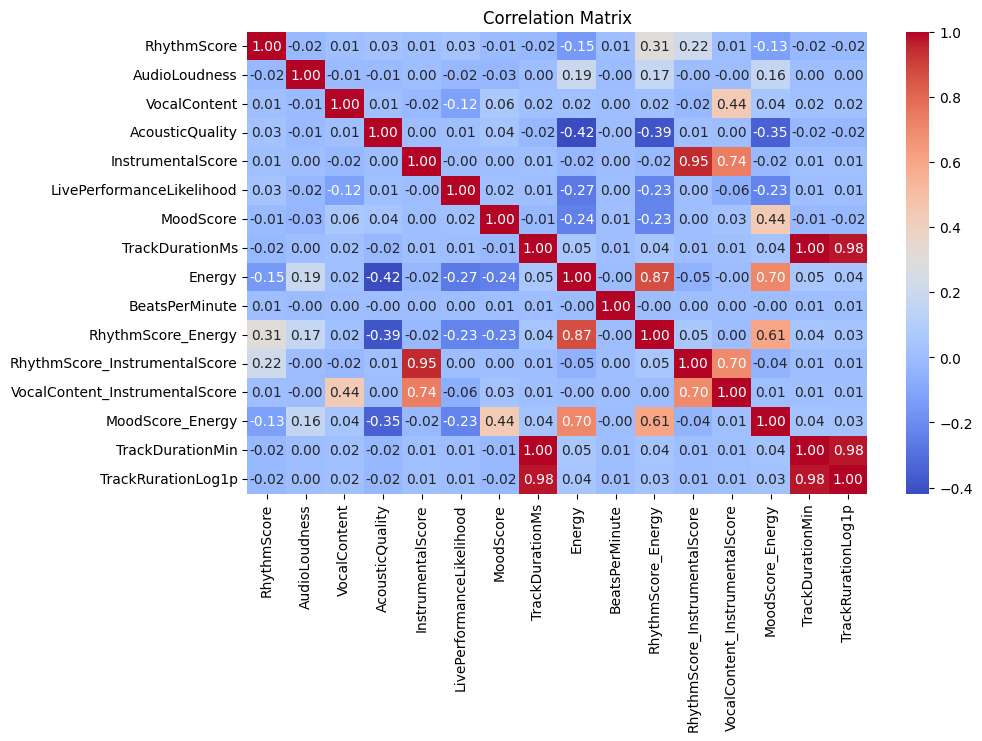

In [6]:
# Correlação
plt.figure(figsize=(10,6))
sns.heatmap(train.drop(columns=["id"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### **Treatments - Outliers and Assimetric Distribuition** 

In [7]:
def varibles_diagnosis(X, z_thresh=3, plot=True):

    results = []

    for col in X.select_dtypes(include=["float", "int"]).columns:
        serie = X[col].dropna()

        # Outliers via IQR
        Q1, Q3 = serie.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers_iqr = ((serie < (Q1 - 1.5 * IQR)) | (serie > (Q3 + 1.5 * IQR))).sum()

        # Outliers via Z-score
        z_outliers = (np.abs(zscore(serie)) > z_thresh).sum()

        # Skewness e Kurtosis
        skew_val = skew(serie)
        kurt_val = kurtosis(serie)

        # Sugestão de transformação
        if abs(skew_val) > 1:
            if (serie > 0).all():
                sugestao = "Apply log/Box-Cox"
            else:
                sugestao = "Apply Yeo-Johnson"
        else:
            sugestao = "No necessary ajusts"

        results.append({
            "column": col,
            "outliers_IQR": outliers_iqr,
            "outliers_Zscore": z_outliers,
            "skewness": skew_val,
            "kurtosis": kurt_val,
            "sugestao": sugestao
        })

        # Gráficos
        if plot:
            fig, axes = plt.subplots(1, 2, figsize=(10, 3))
            sns.boxplot(x=serie, ax=axes[0], color="skyblue")
            axes[0].set_title(f"Boxplot - {col}")

            sns.histplot(serie, kde=True, ax=axes[1], color="salmon")
            axes[1].set_title(f"Histogram - {col}")

            plt.suptitle(f"{col} Diagnosis")
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(results).set_index("column")

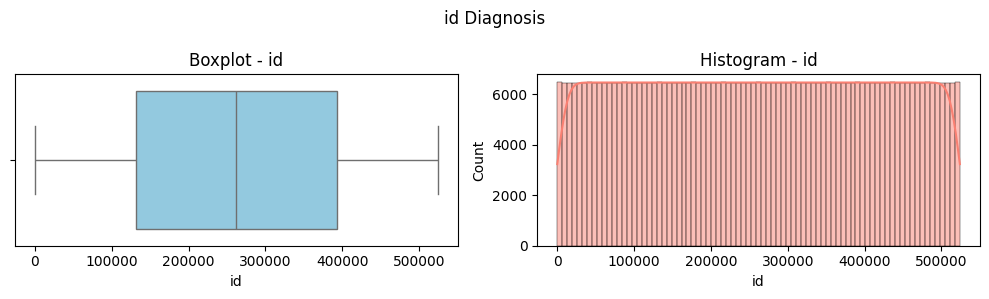

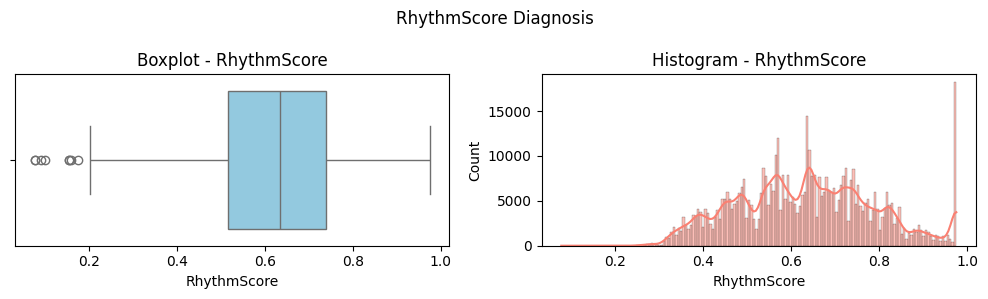

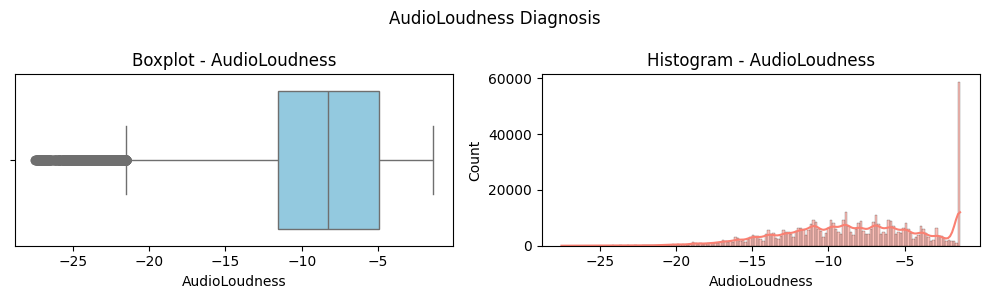

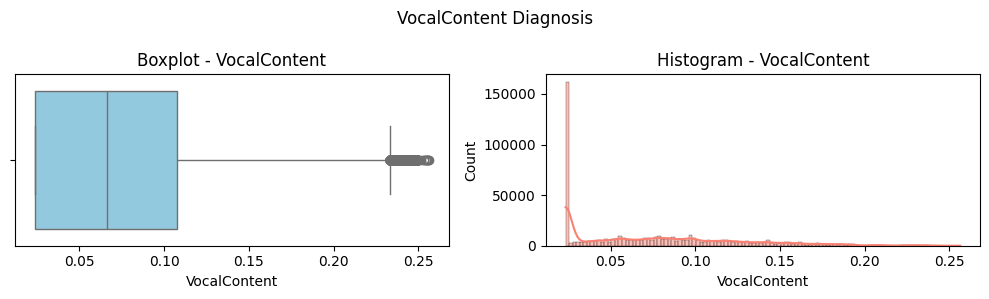

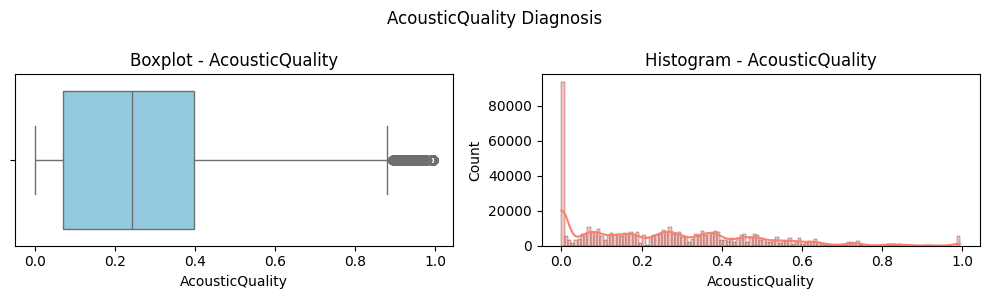

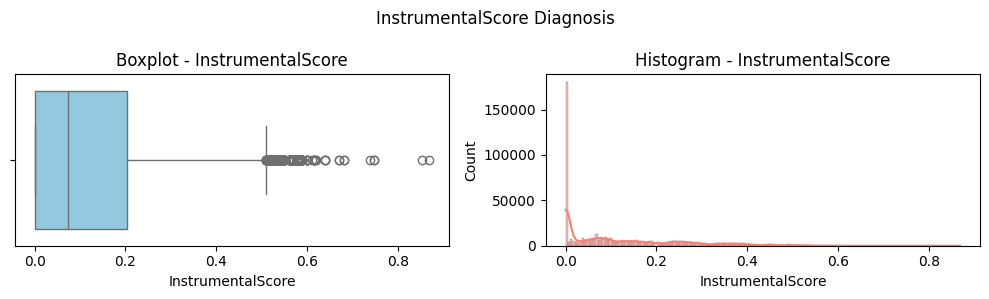

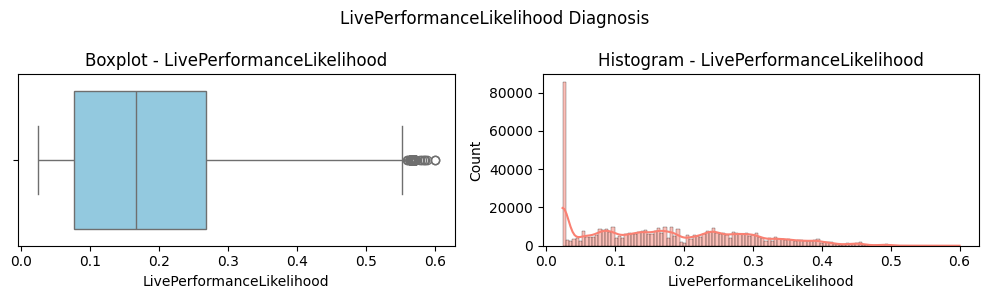

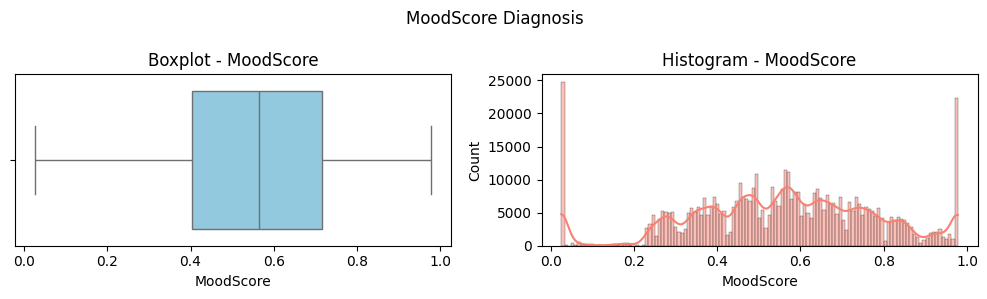

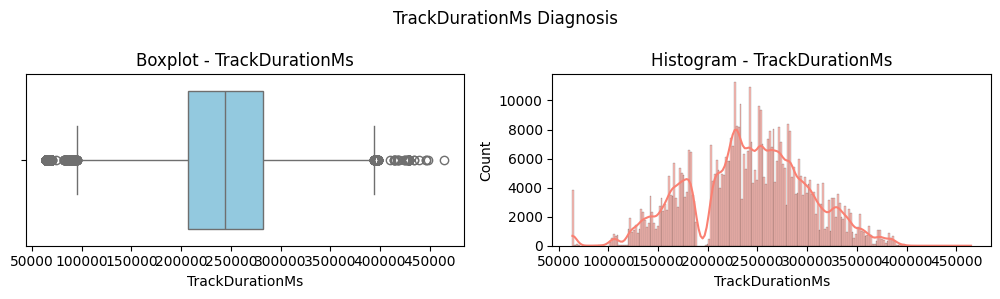

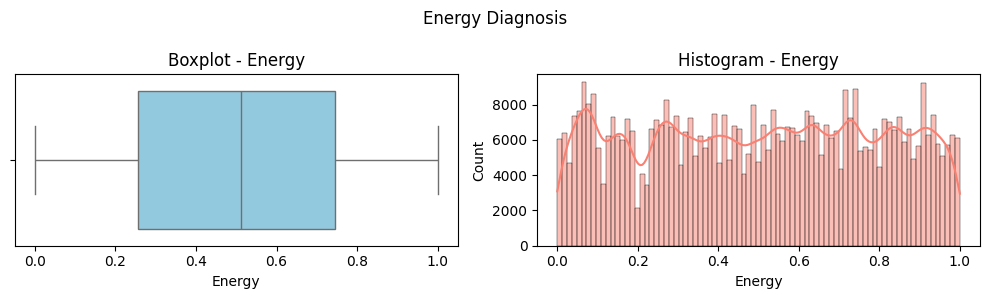

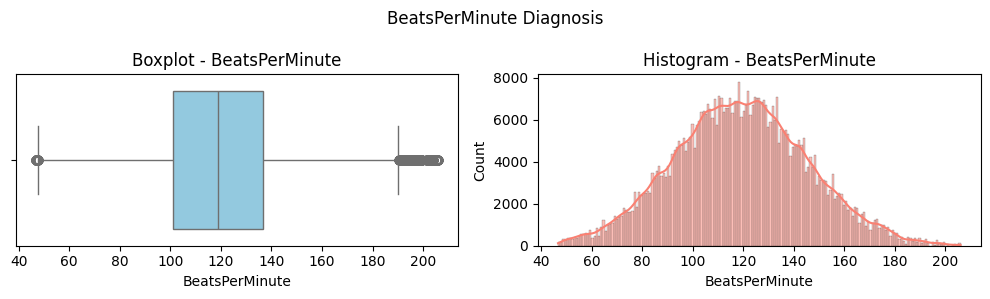

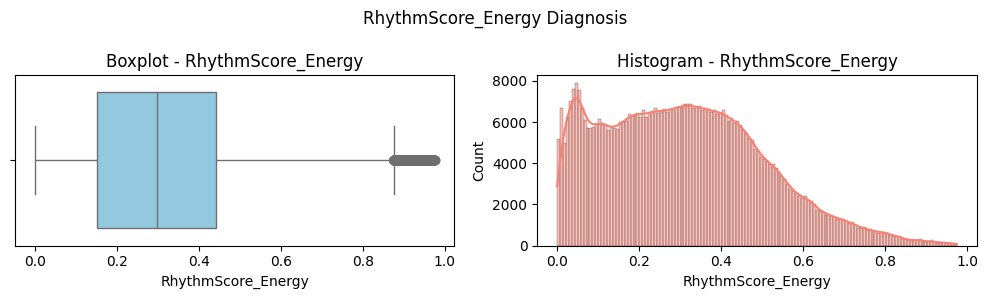

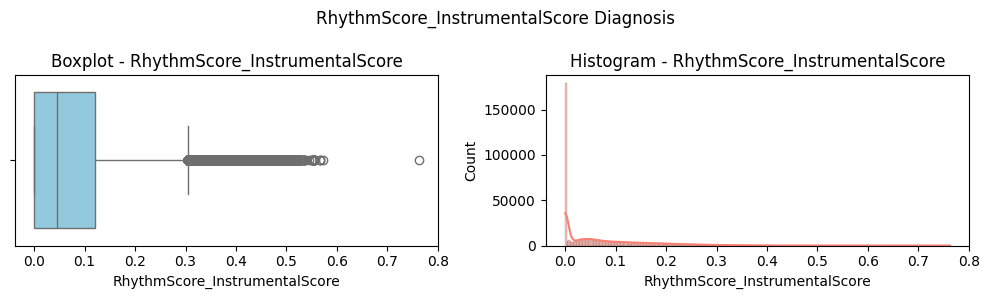

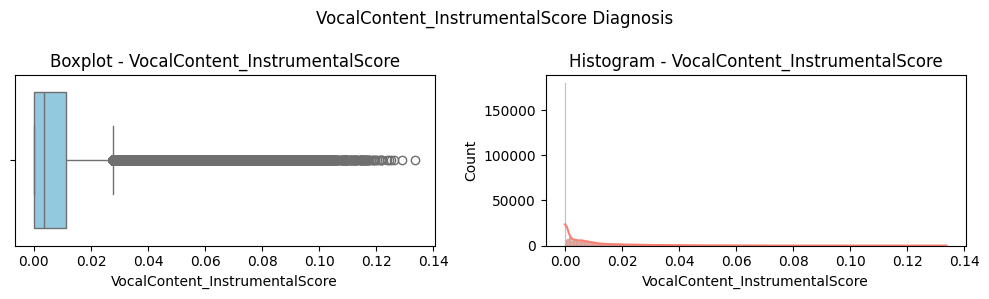

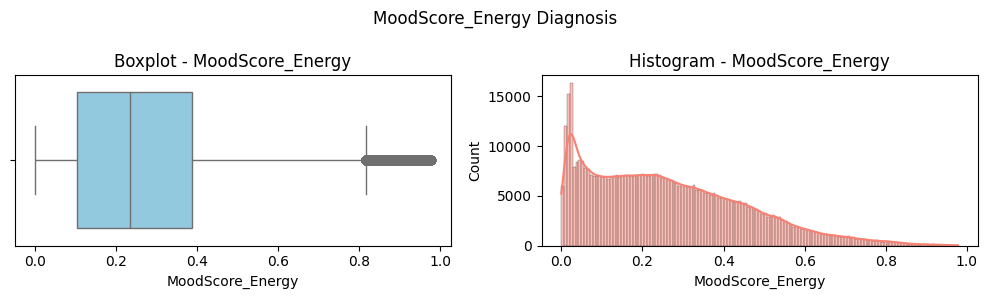

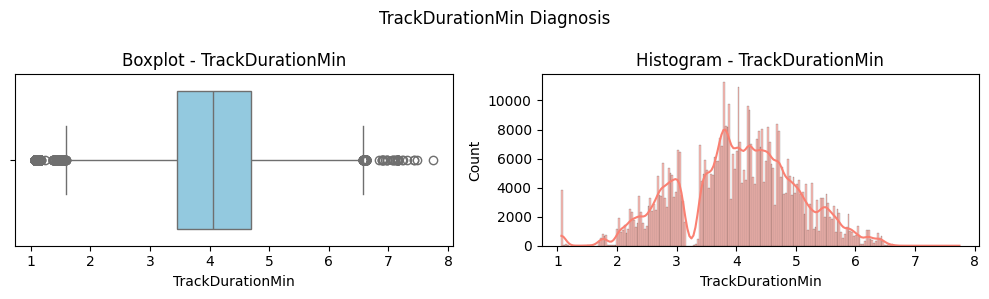

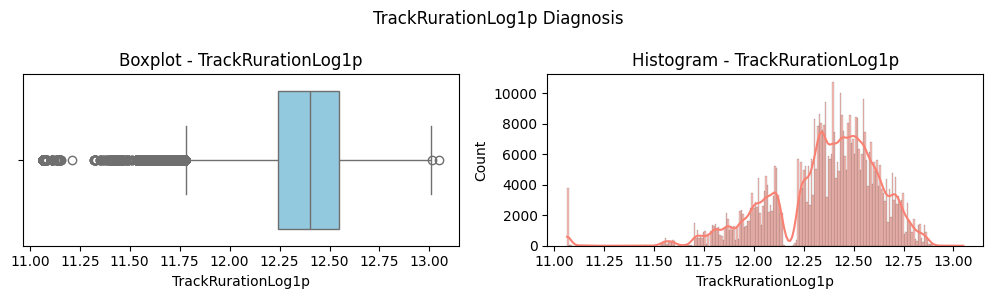

,outliers_IQR,outliers_Zscore,skewness,kurtosis,sugestao
column,,,,,
id,0,0,1.082690e-15,-1.200000,No necessary ajusts
RhythmScore,8,7,1.681541e-01,-0.526738,No necessary ajusts
AudioLoudness,1770,1213,-3.085127e-01,-0.388412,No necessary ajusts
VocalContent,1245,3146,7.891093e-01,-0.147717,No necessary ajusts
AcousticQuality,6746,6007,7.859633e-01,0.267127,No necessary ajusts
InstrumentalScore,2845,2668,1.036282e+00,0.156398,Apply log/Box-Cox
LivePerformanceLikelihood,129,232,3.933205e-01,-0.754141,No necessary ajusts
MoodScore,0,0,-2.688190e-01,-0.142285,No necessary ajusts
TrackDurationMs,4267,23,-1.904823e-01,-0.129164,No necessary ajusts


In [8]:
varibles_diagnosis(train, 3, True)

# Models

In [10]:
X = train.drop(columns=["id", "BeatsPerMinute"])
y = train["BeatsPerMinute"]

In [11]:
def models(X, y, cv_splits=5):
    
    # Base configs
    n_estimators = 500
    learning_rate = 0.05
    max_depth = 6
    subsample = 0.8
    colsample_bytree = 0.8
    random_state = 42
    n_jobs = -1

    # RMSE
    rmse_scorer = make_scorer(mean_squared_error)

    # Models
    models_dict = {
        "Linear": LinearRegression(),
        "Dummy": DummyRegressor(strategy="mean"),
        "XGBoost": XGBRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
            subsample=subsample, colsample_bytree=colsample_bytree, random_state=random_state, n_jobs=n_jobs
        ),
        "RandomForest": RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs
        ),
        "LightGBM": LGBMRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, force_row_wise=True, verbose=-1
        ),
        "CatBoost": CatBoostRegressor(
            n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state, verbose=0
        ),
        "SVR": SVR(C=10, kernel="rbf"),
        "MLP": MLPRegressor(
            hidden_layer_sizes=(64, 32), activation="relu", solver="adam", max_iter=n_estimators, random_state=random_state
        )
    }

    # K-Fold CV
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    metrics_results = []
    predictions = pd.DataFrame({"y": y.values})
    coef_df = pd.DataFrame(index=X.columns)

    for name, model in models_dict.items():
        # Cross-validation for RMSE
        scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=cv)
        metrics_results.append({
            "model": name,
            "rmse_mean": np.mean(scores),
            "rmse_std": np.std(scores)
        })

        # Fit for each model
        model.fit(X, y)
        predictions[name] = model.predict(X)

        # Coef
        if name == "Linear":
            coef_df[name] = model.coef_
            
        elif name in ["XGBoost", "RandomForest", "LightGBM", "CatBoost"]:
            coef_df[name] = model.feature_importances_

            if name == "LightGBM":
                fi = model.feature_importances_
                fi_norm = fi / fi.sum()
                coef_df["LightGBM_norm"] = fi_norm
                
        elif name in ["SVR", "MLP"]:
            # Permutation importance
            result = permutation_importance(model, X, y, n_repeats= 5, random_state=random_state, 
                                            n_jobs=n_jobs, scoring=rmse_scorer)
            coef_df[name] = result.importances_mean
    
    metrics_df = pd.DataFrame(metrics_results)

    return predictions, metrics_df, coef_df

### Fit 01 - All Data
Definition: Fitting all data and without any treament applied.

In [12]:
predictions, metrics_df, coef_df = models(X[:10000], y[:10000], 5)

In [13]:
fit01_predictions = predictions.copy()
fit01_predictions.head()

,y,Linear,Dummy,XGBoost,RandomForest,LightGBM,CatBoost,SVR,MLP
0,147.53020,118.381054,119.018355,130.730759,118.358352,123.424004,120.495749,118.307224,142.769650
1,136.15963,118.763793,119.018355,126.675430,118.969345,118.781212,118.993121,118.616747,77.684795
2,55.31989,117.752193,119.018355,86.632423,115.950060,100.005502,102.892829,118.604827,82.704655
3,147.91212,118.961604,119.018355,125.895958,119.456417,121.615457,121.087291,118.531734,111.937217
4,89.58511,119.101692,119.018355,112.186081,118.074796,115.182088,117.281892,118.560598,103.043872


In [14]:
fit01_metrics = metrics_df.copy()
fit01_metrics

,model,rmse_mean,rmse_std
0,Linear,714.256985,14.121741
1,Dummy,713.240607,14.094099
2,XGBoost,757.517510,18.439113
3,RandomForest,714.354285,14.421793
4,LightGBM,755.660678,15.283526
5,CatBoost,729.188921,13.519298
6,SVR,714.101931,14.510524
7,MLP,1563.095238,43.674555


In [15]:
fit01_coef = coef_df.copy()
fit01_coef

,Linear,XGBoost,RandomForest,LightGBM,LightGBM_norm,CatBoost,SVR,MLP
RhythmScore,6.820731e-01,0.099633,0.119236,1535,0.115457,12.376910,-1.676199e-10,0.064589
AudioLoudness,3.824874e-02,0.101713,0.103560,1474,0.110869,9.896217,-1.058722e-07,-0.514224
VocalContent,5.244355e-01,0.109476,0.100140,1365,0.102670,9.560769,-1.591616e-12,-0.002301
AcousticQuality,3.213964e-01,0.109525,0.097168,1536,0.115532,10.687031,-1.512035e-10,-0.031048
InstrumentalScore,-1.011759e+00,0.110301,0.075982,1152,0.086649,9.679103,-3.042715e-10,0.022038
LivePerformanceLikelihood,3.577409e+00,0.113896,0.125397,1381,0.103874,10.844632,-1.031935e-09,0.007839
MoodScore,-1.896150e-01,0.114916,0.107312,1471,0.110643,12.676601,-3.885816e-11,-0.039564
TrackDurationMs,-5.352040e-07,0.120907,0.139161,1677,0.126138,12.678550,-2.058503e-01,-3.982796
Energy,-6.252739e-01,0.119633,0.132044,1704,0.128168,11.600186,9.051746e-10,0.018151


### Fit 02 - All Data and Scaler Treament
Definition: 

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns= X.columns)

In [17]:
predictions, metrics_df, feature_importances_df = models(X_scaled[:10000], y[:10000], 5)

In [18]:
fit02_predictions = predictions.copy()
fit02_predictions.head()

,y,Linear,Dummy,XGBoost,RandomForest,LightGBM,CatBoost,SVR,MLP
0,147.53020,118.381054,119.018355,126.703430,118.359934,124.240048,119.236199,118.481905,120.689312
1,136.15963,118.763793,119.018355,125.112526,118.968289,120.115255,120.491320,111.527550,112.817802
2,55.31989,117.752193,119.018355,91.892258,115.915088,100.115238,103.942357,114.029854,113.585100
3,147.91212,118.961604,119.018355,126.831848,119.466881,127.779361,120.513940,123.974932,121.463533
4,89.58511,119.101692,119.018355,110.193115,118.076719,114.618893,115.142888,118.334787,115.102976


In [19]:
fit02_metrics = metrics_df.copy()
fit02_metrics

,model,rmse_mean,rmse_std
0,Linear,714.256985,14.121741
1,Dummy,713.240607,14.094099
2,XGBoost,758.701892,17.995163
3,RandomForest,714.355019,14.415333
4,LightGBM,757.568151,12.632651
5,CatBoost,729.775017,13.735029
6,SVR,735.576184,14.642830
7,MLP,749.133174,14.155632


In [20]:
fit02_coef = coef_df.copy()
fit02_coef

,Linear,XGBoost,RandomForest,LightGBM,LightGBM_norm,CatBoost,SVR,MLP
RhythmScore,6.820731e-01,0.099633,0.119236,1535,0.115457,12.376910,-1.676199e-10,0.064589
AudioLoudness,3.824874e-02,0.101713,0.103560,1474,0.110869,9.896217,-1.058722e-07,-0.514224
VocalContent,5.244355e-01,0.109476,0.100140,1365,0.102670,9.560769,-1.591616e-12,-0.002301
AcousticQuality,3.213964e-01,0.109525,0.097168,1536,0.115532,10.687031,-1.512035e-10,-0.031048
InstrumentalScore,-1.011759e+00,0.110301,0.075982,1152,0.086649,9.679103,-3.042715e-10,0.022038
LivePerformanceLikelihood,3.577409e+00,0.113896,0.125397,1381,0.103874,10.844632,-1.031935e-09,0.007839
MoodScore,-1.896150e-01,0.114916,0.107312,1471,0.110643,12.676601,-3.885816e-11,-0.039564
TrackDurationMs,-5.352040e-07,0.120907,0.139161,1677,0.126138,12.678550,-2.058503e-01,-3.982796
Energy,-6.252739e-01,0.119633,0.132044,1704,0.128168,11.600186,9.051746e-10,0.018151
